In [1]:
import numpy as np
import healpy as hp
import fitsio

In [2]:
import h5py

In [3]:
import matplotlib.pyplot as plt

# Construct weight map 

In [4]:
def hpRaDecToHEALPixel(ra, dec, nside=  4096, nest= False):
    phi = ra * np.pi / 180.0
    theta = (90.0 - dec) * np.pi / 180.0
    hpInd = hp.ang2pix(nside, theta, phi, nest= nest)
    return hpInd

In [31]:
def catalog_to_weight_map(catalog=None, nside=125, nest=False, mask = None, hpixtag='PIXEL', fracdettag='FRAC', ratag='RA', dectag='DEC', wtag='WEIGHT'):    
    # convert catalog to weight and fracdet maps
    
    ra = catalog[ratag]    
    dec = catalog[dectag] 
    weight = catalog[wtag]
    hpindex = hpRaDecToHEALPixel(ra, dec, nside= nside, nest= nest)   
    empty_healmap = np.bincount(hpindex,minlength=hp.nside2npix(nside), weights=weight)
    #empty_healmap[empty_healmap==0.0] = hp.UNSEEN
    
    hpfracdet = mask[hpixtag]
    #empty_fracdet = np.full(hp.nside2npix(4096), hp.UNSEEN)
    empty_fracdet = np.zeros(hp.nside2npix(4096))
    empty_fracdet[hpfracdet] = mask[fracdettag]
    empty_fracdet_downgrade = hp.ud_grade(empty_fracdet, nside)
    
    #weightmap = empty_healmap*1./empty_fracdet_downgrade
    #weightmap[hp.mask_bad(empty_healmap) | hp.mask_bad(empty_fracdet_downgrade)] = hp.UNSEEN    
    #goodmask = hp.mask_good(empty_healmap) | hp.mask_good(empty_fracdet_downgrade)
    #import ipdb 
    #ipdb.set_trace()
    
    data = np.zeros( empty_healmap.size, dtype=[('HPIX', 'i8'),('VALUE','f8'), ('FRAC', 'f8')])
    
    hpindarray = np.arange(hp.nside2npix(nside))
    data['HPIX'] = hpindarray  #[goodmask]
    data['VALUE'] = empty_healmap  #[goodmask]
    data['FRAC'] = empty_fracdet_downgrade #[goodmask]
    return data

In [6]:
# dmass 
dmass = fitsio.read('dmass_cat/dmass_y1_public_v1.fits')
dmass = dmass[dmass['VETO'] != 0]
# random
random = fitsio.read('dmass_cat/random_dmass_y1_public_v1.fits')
random = random[random['VETO'] != 0]
# mask
mask = fitsio.read('dmass_cat/mask_dmass.fits')

In [7]:
print(dmass.dtype.names), print(mask.dtype.names), print(random.dtype.names)

('COADD_OBJECTS_ID', 'RA', 'DEC', 'VETO', 'CMASS_PROB', 'WEIGHT_SYS')
('PIXEL', 'FRAC', 'RA', 'DEC')
('RA', 'DEC', 'VETO')


(None, None, None)

In [8]:
dmass_dic = {}
dmass_dic['RA'] = dmass['RA']
dmass_dic['DEC'] = dmass['DEC']
dmass_dic['WEIGHT'] = dmass['CMASS_PROB'] * dmass['WEIGHT_SYS']
weight = dmass_dic['WEIGHT']

In [41]:
outcat = {}
for n in [128, 256, 512,1024,2048,4096]:
    print (n)
    outcat[str(n)] = catalog_to_weight_map(catalog=dmass_dic, nside=n, nest=False, mask = mask)
    #hp.write_map('dmass_cat/ngalmap/'+"wmap_y1dmass_nside{}_RING.fits".format(str(n)), outcat[str(n)] , overwrite=True ,fits_IDL=False)
    fitsio.write(f"dmass_cat/ngalmap/wmap_y1dmass_nside{n}_RING.fits", outcat[str(n)], clobber=True)

128
256
512
1024
2048
4096


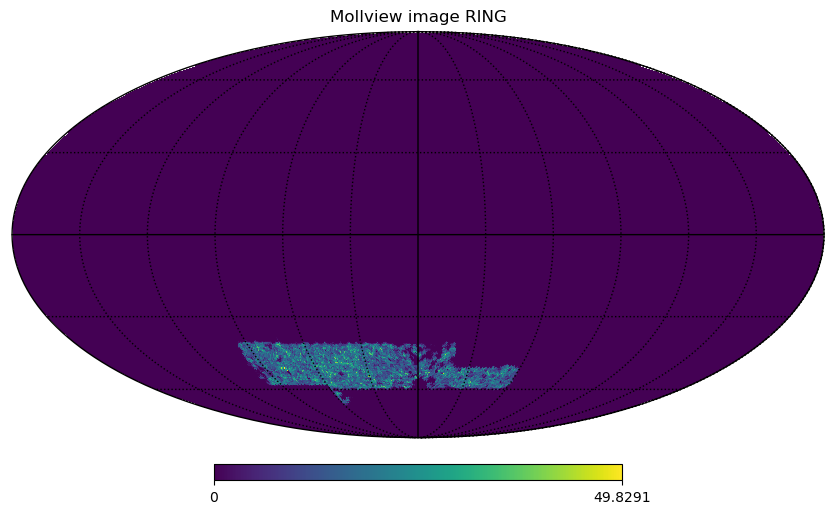

In [33]:
hp.mollview(outcat['128']['VALUE'], title="Mollview image RING")
hp.graticule()

# Measure Skewness

In [155]:
from astropy.io import fits

In [10]:
galmap = 'dmass_cat/ngalmap/wmap_y1dmass_nside{}_RING.fits'

In [34]:
dmass = fitsio.read(galmap.format(128))

In [38]:
from fitting import ngal_to_deltamap, fit_lnshift_deltamap, lognormal_pdf

0
[1.50119502 0.33301223]
[0.08539425 0.00359387]
0
[1.52667843 0.5070737 ]
[0.02759485 0.00258158]
0
[1.49696555 0.86225315]
[0.09824502 0.02597764]


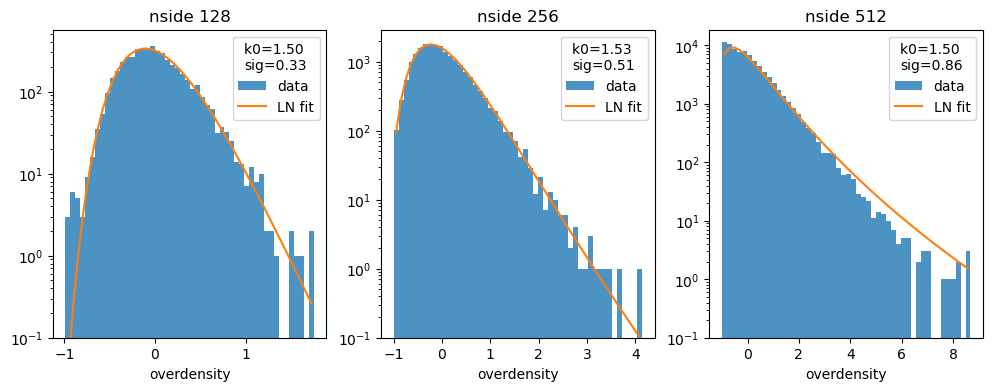

In [55]:
nsidelist = [128, 256, 512 ] #,1024,2048,4096]
fig,axes = plt.subplots(1, 3, figsize=(12,4))
for i, nside in enumerate(nsidelist):
    #masking
    ax=axes.ravel()[i]

    #dmass = fits.open(galmap.format(nside))[1].data
    dmass = fitsio.read(galmap.format(nside))

    mymask = dmass['FRAC']>0.8 #avoid crazy outliers due to dividing by small fracdet
    # converting gal sample to pixel map
    mydelta = ngal_to_deltamap(dmass['VALUE'], dmass['FRAC'], mymask)

    #mymock = fits.open(root_dir+galmap_fns_maglim[iz].format(512))[1].data
    #mymask = mymock['FRACDET']>0.5 #avoid crazy outliers due to dividing by small fracdet
    ## converting gal sample to pixel map
    #mydelta = ngal_to_deltamap(mymock['VALUE'], mymock['FRACDET'], mymask)
    
    # fitting
    popt, pcov, binedges, binmids, counts = fit_lnshift_deltamap(mydelta[mymask], bins=50)
    _ = ax.hist(mydelta[mymask], bins=binedges, alpha=0.8, label='data')
    ax.plot(binmids, lognormal_pdf(binmids, *popt) * np.trapz(counts, binmids), label='LN fit')
    ax.set_yscale('log')
    print(iz)
    print(popt)
    pcovi = [pp**0.5 for pp in pcov.diagonal()]
    print(f'[{pcovi[0]:.8f} {pcovi[1]:.8f}]')
    #textfile.write(f'{popt[0]:.5f} {popt[1]:.5f} {pcovi[0]:.5f} {pcovi[1]:.5f} \n')
    
    ax.legend(title=f'k0={popt[0]:.2f} \nsig={popt[1]:.2f}')
    ax.set_title('nside {}'.format(nside))
    ax.set_xlabel('overdensity')
    ax.set_ylim(0.1, None)
    #plt.grid()
#textfile.close()
#fig.savefig('plots/skewness_fitting_data.png')